# Samplers Comparison

##### Imports

In [1]:
import warnings
from tqdm import TqdmWarning

warnings.filterwarnings("ignore", category=TqdmWarning)

In [2]:
import numpy as np
import torch
from torch import nn, optim
from tqdm import tqdm
from kilroyplot.plot import plt
from kilroyshare.codec import Codec
from kilroytorch.modules.online import BasicOnlineModule as OnlineModule
from kilroytorch.models.distribution.sequential import (
    CategoricalSequentialDistributionModel as Model,
)
from kilroytorch.adapters import SequentialDataAdapter as Adapter
from kilroytorch.generators import SequentialGenerator as Generator
from kilroytorch.samplers import categorical as samplers

## Task

In [3]:
n_classes = 100
max_length = 20

## Model

In [4]:
class DummyCodec(Codec):
    def encode(self, value):
        return value.flatten().tolist()

    def decode(self, value):
        return torch.tensor(value).view(-1, 1)

In [5]:
samplers = {
    "proportional": samplers.ProportionalCategoricalSampler(),
    "epsilon-proportional": samplers.EpsilonProportionalCategoricalSampler(0.01),
    "top-k": samplers.TopKCategoricalSampler(90),
    "epsilon-top-k": samplers.EpsilonTopKCategoricalSampler(0.01, 90),
    "nucleus": samplers.NucleusCategoricalSampler(0.99),
    "epsilon-nucleus": samplers.EpsilonNucleusCategoricalSampler(0.01, 0.99),
}

## Training

In [6]:
n_iters = 500
iter_size = 512

In [7]:
def train(module, n_iters, iter_size):
    mean_scores = []
    for i in tqdm(range(n_iters)):
        scores = {key: score(value, i) for key, value in module.sample(iter_size)}
        mean_scores.append(np.mean(list(scores.values())))
        metrics = module.fit(scores)
        module = module.step()
    return mean_scores


def train_all(samplers):
    mean_scores = {}

    for name, sampler in samplers.items():
        model = Model(n_classes)
        module = OnlineModule(
            model,
            Generator(sampler, max_length),
            Adapter(),
            DummyCodec(),
            optim.Adam(model.parameters(), lr=0.01),
        )
        mean_scores[name] = train(module, n_iters, iter_size)

    return mean_scores

In [8]:
def plot(mean_scores):
    nrows, ncols = 1 + int((len(mean_scores) - 1) / 2), min(2, len(mean_scores))
    scale = 6
    fig, axs = plt.subplots(
        nrows,
        ncols,
        figsize=(scale * ncols, scale * nrows),
        sharex="all",
        sharey="all",
        squeeze=False,
    )
    fig.suptitle("Mean scores of generated samples")
    for i, (sampler, scores) in enumerate(mean_scores.items()):
        ax = axs.flatten()[i]
        ax.plot(scores)
        ax.set_title(sampler)
        ax.set_xlabel("iteration")
        ax.set_ylabel("mean score")
    plt.tight_layout()

### Stationary

In [9]:
def score(value, timestep):
    if len(value) > 10:
        return -1
    mid = n_classes // 2
    return ((1 - (np.abs(np.array(value) - mid) / mid)) ** 9).clip(0).sum()

In [10]:
mean_scores = train_all(samplers)

100%|██████████| 500/500 [00:46<00:00, 10.65it/s]


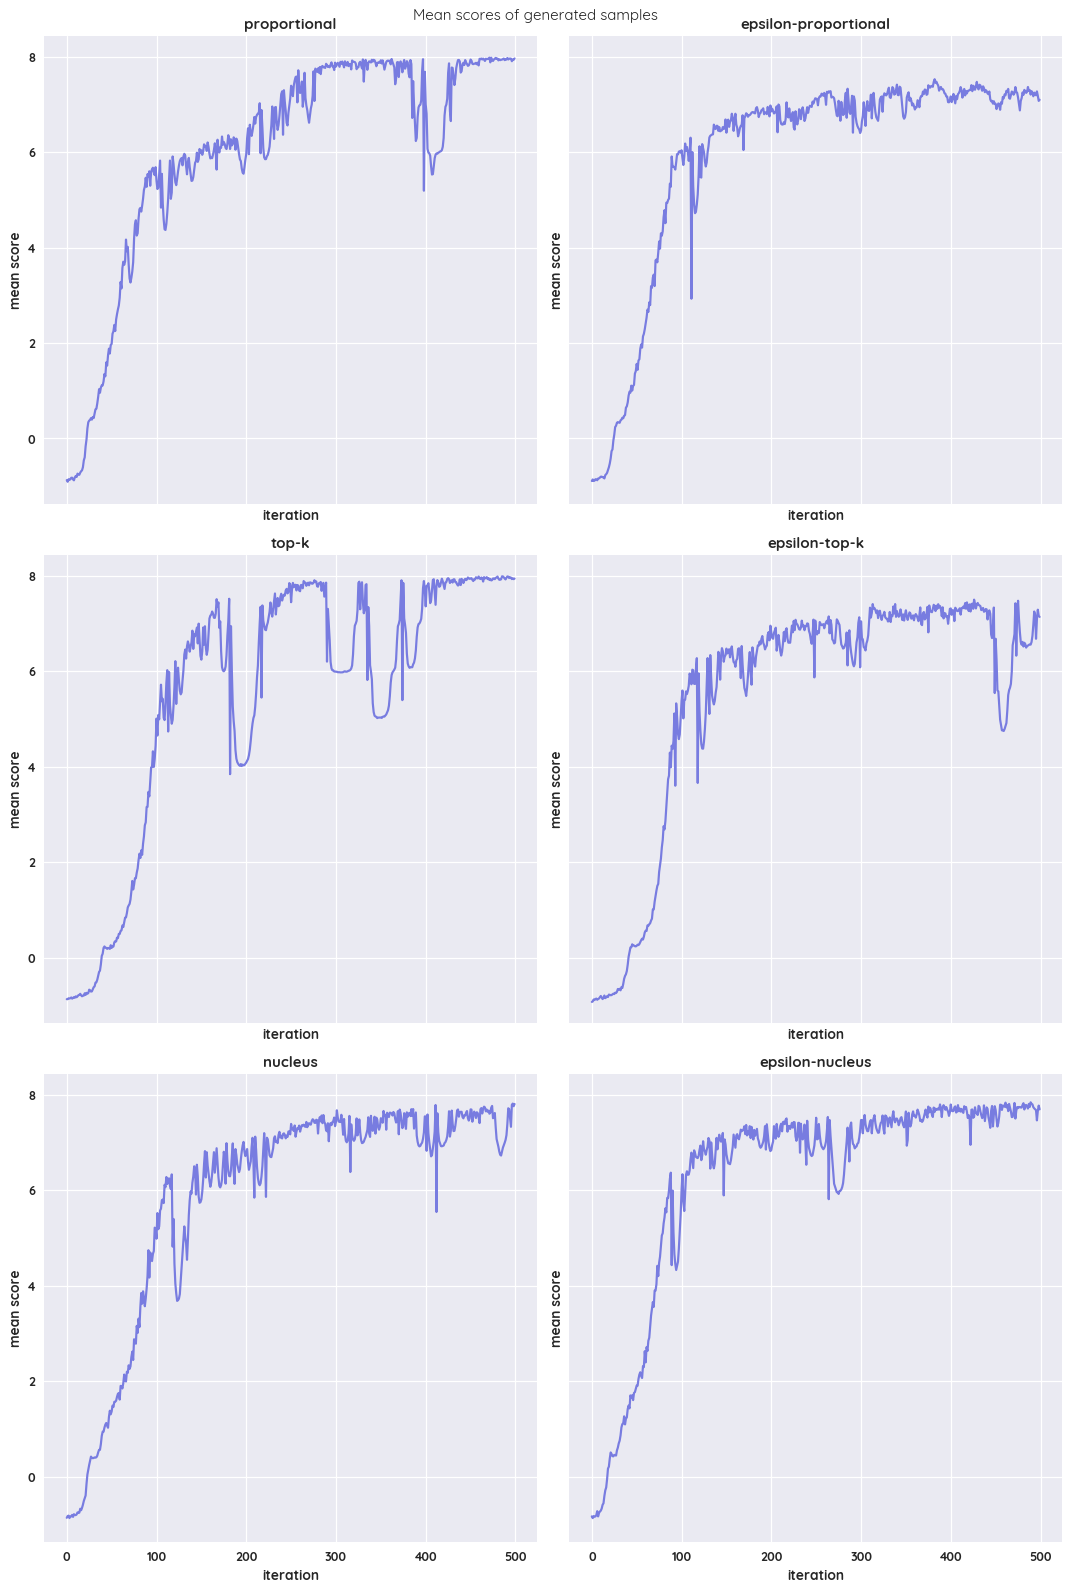

In [11]:
plot(mean_scores)

### Non-stationary

In [12]:
def score(value, timestep):
    if len(value) > 10:
        return -1
    mid = int(n_classes * 0.25) if timestep < 0.5 * n_iters else int(n_classes * 0.75)
    return ((1 - (np.abs(np.array(value) - mid) / mid)) ** 9).clip(0).sum()

In [13]:
mean_scores = train_all(samplers)

100%|██████████| 500/500 [00:47<00:00, 10.44it/s]


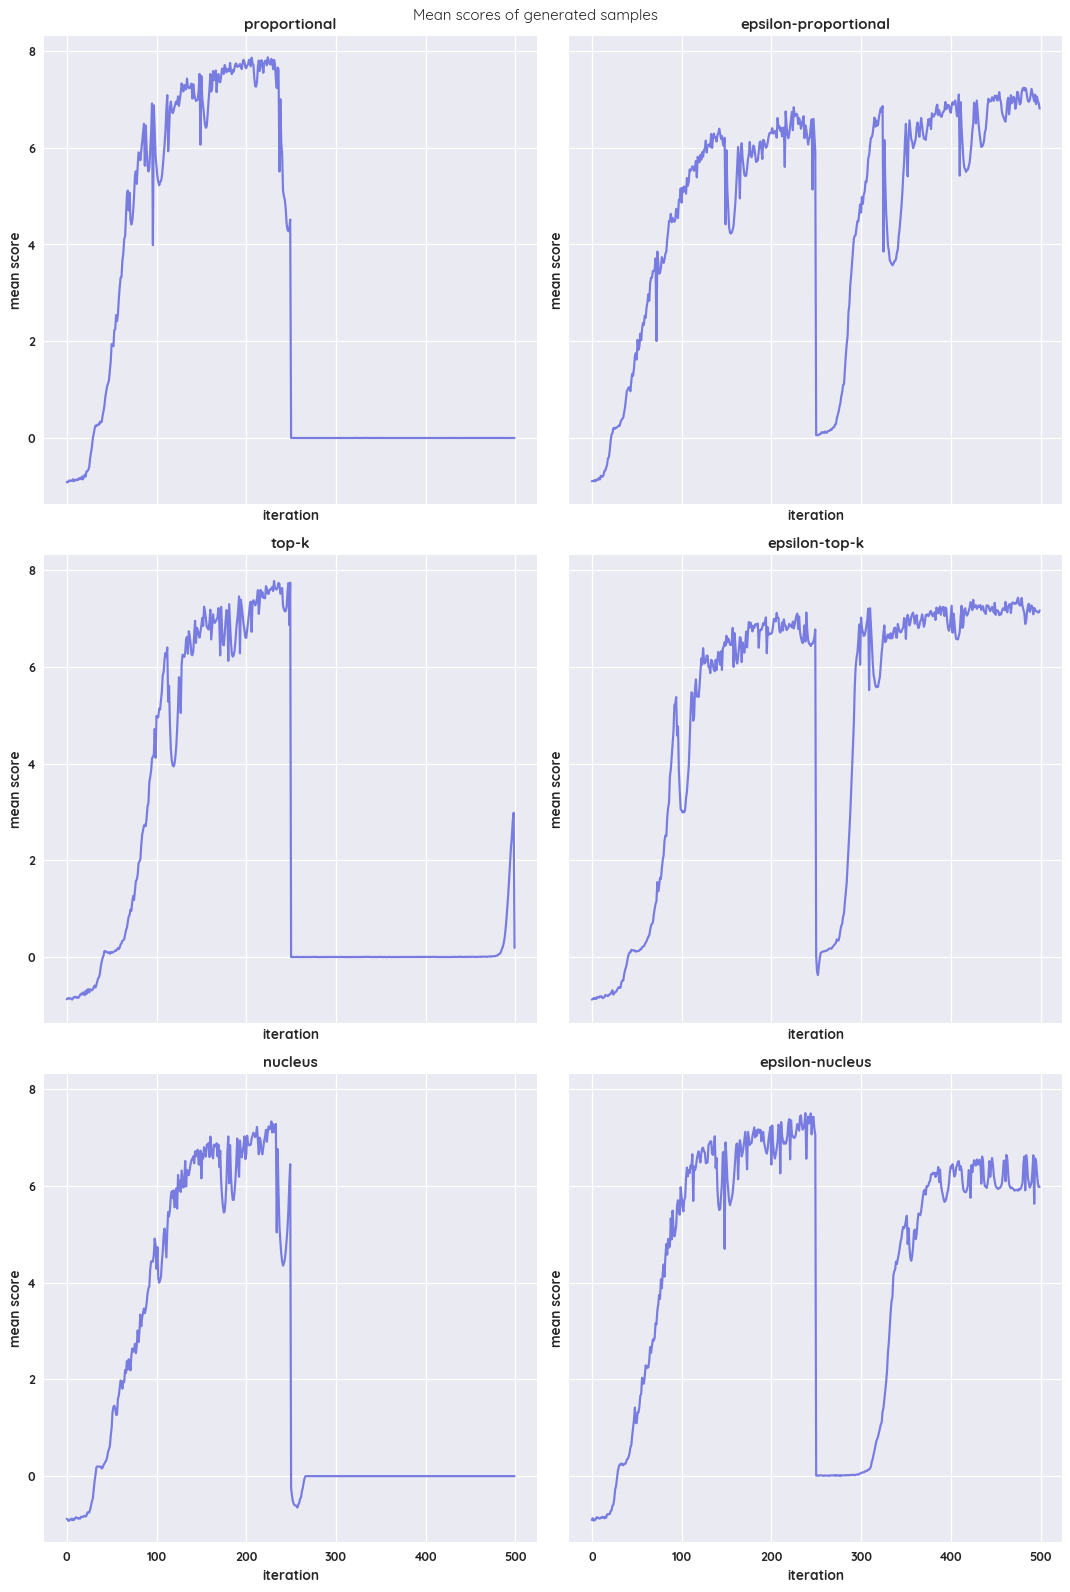

In [14]:
plot(mean_scores)